In [1]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from contextlib import closing
import urllib.request as request
import numpy as np
import ahocorasick
from Bio import SeqIO
import hashlib
from pyteomics import mztab
from matplotlib_venn import venn3

In [3]:
'''
General
'''
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines-benchmark/'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
peps_id_dir = 'peptide_ids'
checksums_file = 'checklist.chk'

#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

#get protein IDs from the contaminated database
conatm_ids = '|'.join([x.strip('>').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [4]:
#Get list of samples
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

samples_list = [ x for x in samples_list if "PXD005942" not in x ]

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 10
Number of Samples completed: 10


In [5]:
checksums = {}
try:
    lines = []
    ftp.retrlines('RETR {}'.format(checksums_file), lines.append)
    for line in lines:
        checksums[line.strip().split(' ')[-1].lstrip('./')] = line.strip().split(' ')[0]
except ftplib.error_perm as e: #the search is not done yet!
    print('Failed to get checksums file: {} in {}'.format(checksums_file, ftp.pwd(), e))

In [6]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD005946-Sample-39, #Peptides: 54476
Sample PXD005946-Sample-39-ref-noncanonical-miss2, #Peptides: 54157
Sample PXD005946-Sample-39-ref-noncanonical-variants-decoy-DeBruijn-miss2, #Peptides: 55517
Sample PXD005946-Sample-39-ref-noncanonical-variants-decoy-pyrat-miss1, #Peptides: 55333
Sample PXD005946-Sample-39-ref-noncanonical-variants-decoy-pyrat-miss2, #Peptides: 55273
Sample PXD005946-Sample-39-ref-noncanonical-variants-miss2, #Peptides: 54477
Sample PXD005946-Sample-39-ref-proteome-miss2, #Peptides: 60471
Sample PXD005946-Sample-39-ref-proteome-variants-miss2, #Peptides: 60413
Sample: checklist.chk, error: 550 Failed to open file.
Sample: debug, error: 550 Failed to open file.


In [7]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))


Extracted 450117 peptides from 8 Samples, Avg. Peptides per Sample: 56264.625



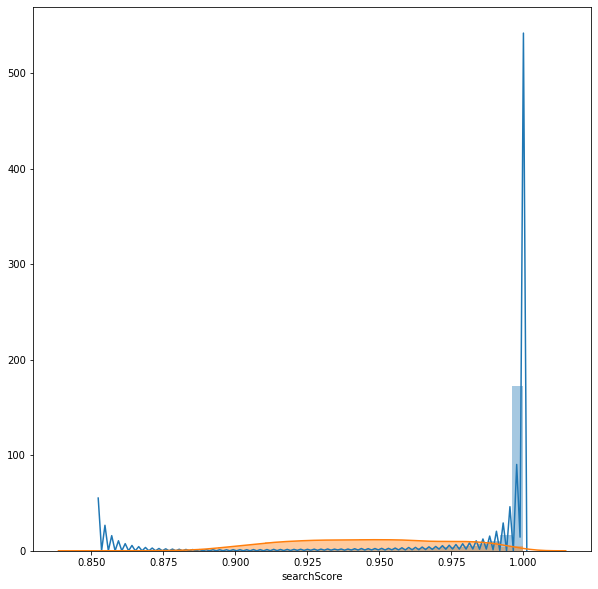

In [8]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

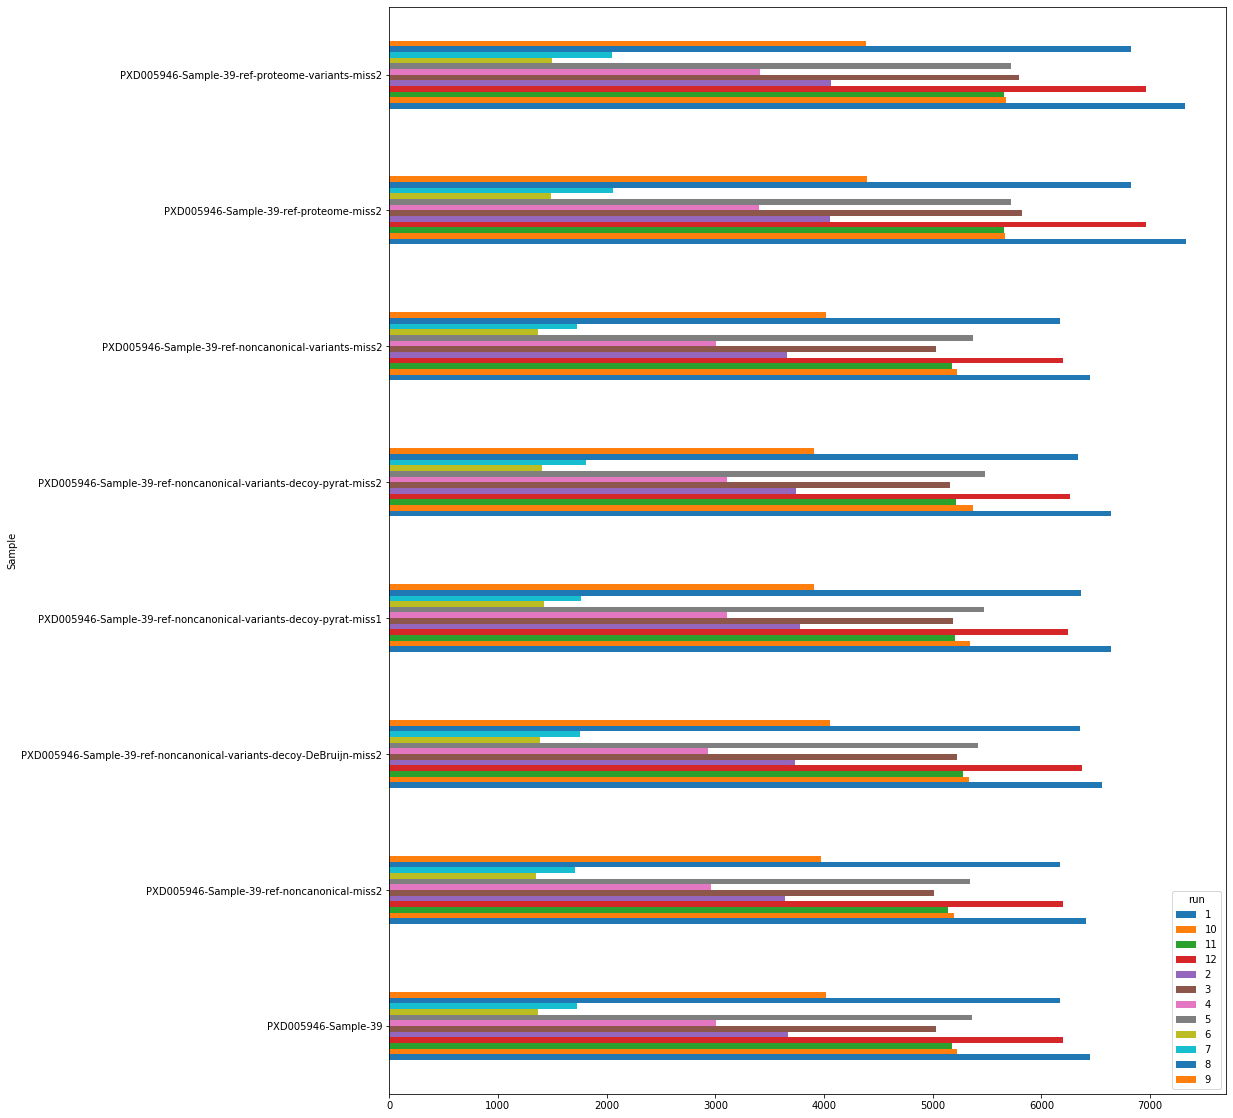

In [9]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
triqler_targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()

In [10]:
conditions = [(triqler_targets['proteins'].str.contains("ENSP") & ~triqler_targets['proteins'].str.contains(conatm_ids)),
        (~(triqler_targets['proteins'].str.contains("ENSP")|triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(triqler_targets['proteins'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"COSMIC|cbiomut")),
        (triqler_targets['proteins'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
triqler_targets['Class'] = np.select(conditions, classes)
triqler_targets['Class'].value_counts()

/Users/yperez/local-apps/miniconda3/envs/jupyternotebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


canonical        407513
non_canonical     23669
contaminant        6966
variant            3837
Name: Class, dtype: int64

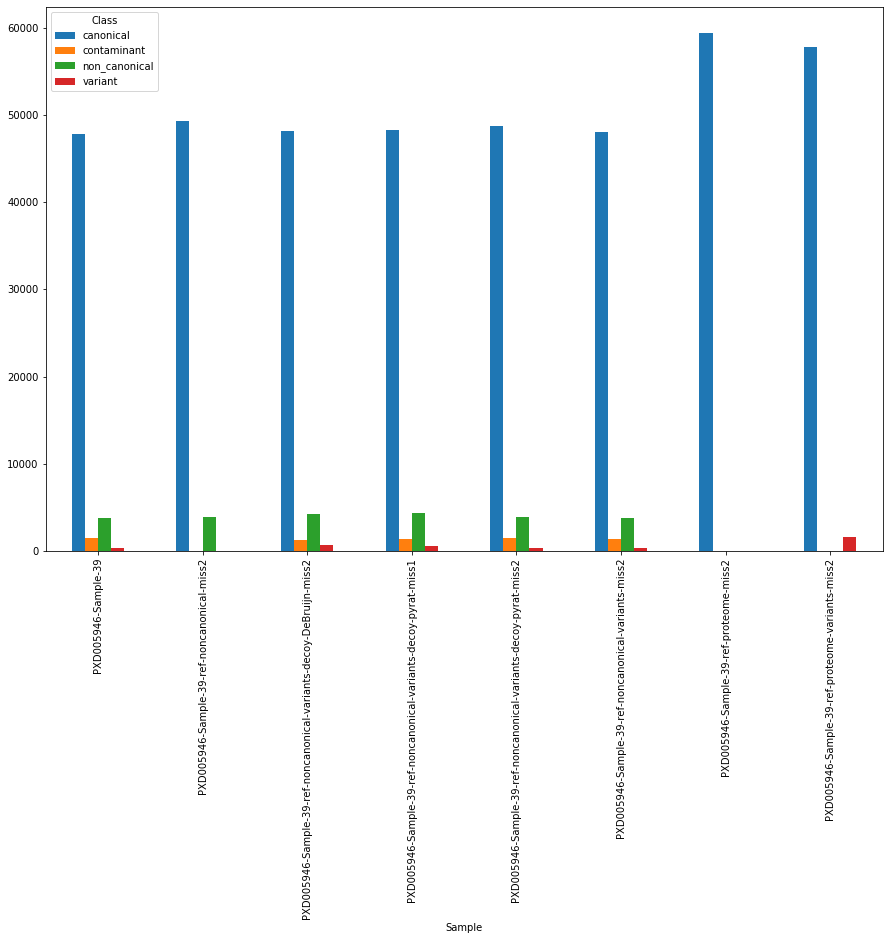

In [11]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [12]:
triqler_targets.to_csv('all_'+triqler_file_name, sep='\t', index=False)

In [13]:
triqler_noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical")==True]
triqler_noncan_seqs = list(set([rep(x) for x in triqler_noncan_targets['peptide'].tolist()]))

In [14]:
#get non-canonical peptides that are found in canonical proteins
triqler_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in triqler_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        triqler_found_peps.append(found)

In [15]:
triqler_noncan_targets = triqler_noncan_targets[triqler_noncan_targets['peptide'].apply(rep).isin(triqler_found_peps)==False]

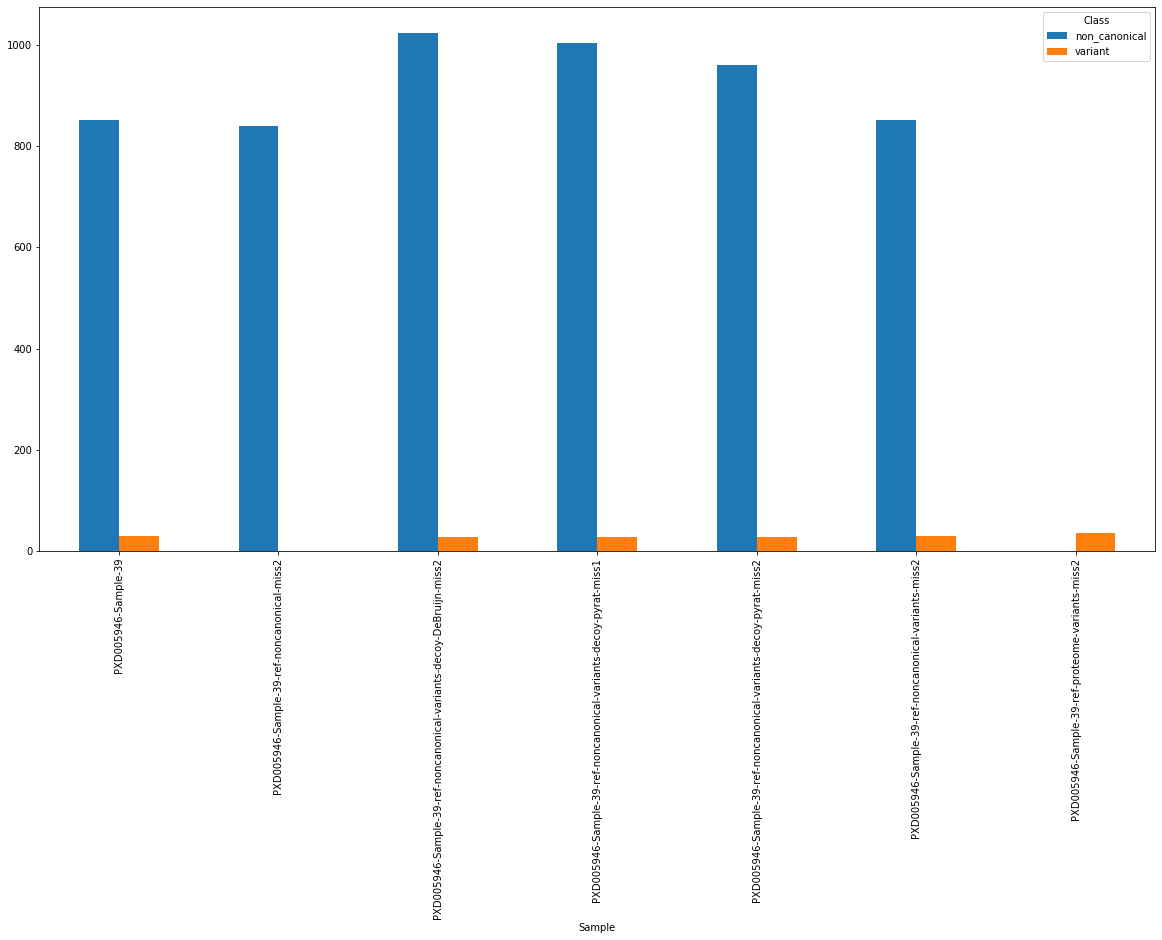

In [16]:
plt.rcParams["figure.figsize"] = [20, 10]
triqler_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [26]:
'''
                ******mzTabl processing******
'''

'\n                ******mzTabl processing******\n'

In [30]:
#Download mzTab files to a local directory to minimize running time in later runs

#create id output directory if it does not exist
if not os.path.isdir(peps_id_dir):
    os.makedirs(peps_id_dir)
download_files = []
for sample in samples_list:
    try:
        remote_file_size = ftp.size('{}/{}/{}'.format(sample, id_dir, mzTab_file_name))
    except ftplib.error_perm as e: #the search is not done yet!
        print('No file is found for sample {}, error:{}'.format(sample, e))
        continue #to next sample
    
    file_url = 'http://{}/{}/{}/{}/{}'.format(ftp_url, samples_dir, sample, id_dir, mzTab_file_name)
    outfile = '{}/{}_{}'.format(peps_id_dir, sample, mzTab_file_name)
    
    remote_checksum = checksums['{}/{}/{}'.format(sample, id_dir, mzTab_file_name)]
    local_file_size = 0
    local_checksum = ''
    try:
        local_file_size = os.path.getsize(outfile)
        local_checksum = hashlib.md5(open(outfile, 'rb').read()).hexdigest()
    except FileNotFoundError:
        pass
    if local_file_size != remote_file_size or local_checksum!=remote_checksum:
        print('Downloading:', file_url)
        with closing(request.urlopen(file_url)) as r:
            with open(outfile, 'wb') as f:
                shutil.copyfileobj(r, f)
        ftp.sendcmd('PASV')#just to avoid server timeout
    else:
        print('Already exists: ', outfile)
    download_files.append(outfile)

BrokenPipeError: [Errno 32] Broken pipe

In [29]:
#shorten accessions to save memory
def rep_acc(accessions):
    rep_accessions = []
    for acc in accessions.split(','):
        if acc.startswith('ENSP'):
            rep_accessions.append('ENSP')
        elif acc.split('_')[0] in ['altorf', 'pseudo', 'ncRNA', 'DECOY']:
            rep_accessions.append(acc.split('_')[0])
        elif acc.split(':')[0] in ['COSMIC', 'cbiomut']:
            rep_accessions.append(acc.split(':')[0])
        else:
            rep_accessions.append(acc)
    return ','.join(list(set(rep_accessions)))

In [21]:
#Extract peptides from mzTab files

#get all peptides from the finished samples
mztab_psms_df = pd.DataFrame()
for mzTab_file in glob(peps_id_dir+'/*.mzTab'):
    try:
      sample = mzTab_file.split('/')[-1].split('_')[0]
      tables = mztab.MzTab(mzTab_file)#give the mzTab file content
      psms = tables.spectrum_match_table.loc[:, ['sequence', 'accession', 'search_engine_score[1]']]
      psms['accession'] = psms['accession'].apply(rep_acc)
      psms['Sample'] = sample
      print('Sample {}, #PSMS: {}'.format(sample, len(psms)))
      mztab_psms_df = pd.concat([mztab_psms_df, psms])
    except ValueError: 
       print(sample + "\t Error in File")

In [22]:
mztab_psms_df.columns

Index([], dtype='object')

In [23]:
print('\nExtracted {} PSMs from {} Samples, Avg. PSMs per Sample: {}\n'.format(len(mztab_psms_df), len(set(mztab_psms_df['Sample'])), len(mztab_psms_df)/len(set(mztab_psms_df.Sample))))

KeyError: 'Sample'

In [ ]:
# This plot is for the ditribution of scores of DECOY vs TARGET 
mztab_psms_targets = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == False]
mztab_psms_decoys = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == True]

In [ ]:
len(mztab_psms_targets), len(mztab_psms_decoys)

In [ ]:
plt.figure(figsize=(10, 10))
sns.distplot(mztab_psms_targets.loc[:, 'search_engine_score[1]'], hist=True, kde=True, 
             bins=int(180/5), color='green')
sns.distplot(mztab_psms_decoys.loc[:, 'search_engine_score[1]'], hist=True, kde=True,
             bins=int(180/5), color = 'red')

In [ ]:
# Print the number of psms per Sample
plt.rcParams["figure.figsize"] = [15, 20]
mztab_psms_targets.Sample.value_counts().plot.barh()

In [ ]:
conditions = [(mztab_psms_targets['accession'].str.contains("ENSP") & ~mztab_psms_targets['accession'].str.contains(conatm_ids)),
        (~(mztab_psms_targets['accession'].str.contains("ENSP")|mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"altorf|pseudo|ncRNA")),
        (~(mztab_psms_targets['accession'].str.contains(r"ENSP|altorf|pseudo|ncRNA") | mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"COSMIC|cbiomut")),
        (mztab_psms_targets['accession'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
mztab_psms_targets['Class'] = np.select(conditions, classes)
mztab_psms_targets['Class'].value_counts()

In [ ]:
mztab_psms_targets.to_csv('all_'+mzTab_file_name, sep='\t', index=False)

In [ ]:
mztab_psms_noncan_targets = mztab_psms_targets[mztab_psms_targets['Class'].str.contains(r"variant|non_canonical")==True]
mztab_noncan_seqs = list(set([rep(x) for x in mztab_psms_noncan_targets['sequence'].tolist()]))

In [ ]:
#get non-canonical peptides that are found in canonical proteins
mztab_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in mztab_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        mztab_found_peps.append(found)

In [ ]:
mztab_psms_noncan_targets = mztab_psms_noncan_targets[mztab_psms_noncan_targets['sequence'].apply(rep).isin(mztab_found_peps)==False]

In [ ]:
plt.rcParams["figure.figsize"] = [20, 10]
mztab_psms_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [ ]:
t1=set(mztab_psms_noncan_targets.sequence.apply(rep).tolist())
t2=set(triqler_noncan_targets.peptide.apply(rep).tolist())
inmzTab_notinTriqler = t1-t2
inTriqler_notinmzTab = t2-t1
print('#sequences in mzTab not in triqler {}'.format(len(inmzTab_notinTriqler)))
print('#sequences in triqler not in mzTab {}'.format(len(inTriqler_notinmzTab)))
print('\n')
print('#unique variant peptides:', len(set(mztab_psms_noncan_targets[mztab_psms_noncan_targets['Class']=='variant']['sequence'].tolist())))
print('#unique non_canonical peptides:', len(set(mztab_psms_noncan_targets[mztab_psms_noncan_targets['Class']=='non_canonical']['sequence'].tolist())))